In [1]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm
from scipy.integrate import solve_bvp
from scipy.optimize import minimize, fsolve, brentq

import os
import re

os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric PDE

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

## The Problem consist in infering $ \alpha $

[2.15374797 4.57785946] [-0.04181683 -0.13684286 -0.20017285] [-0.04181683 -0.13684286 -0.20017285]


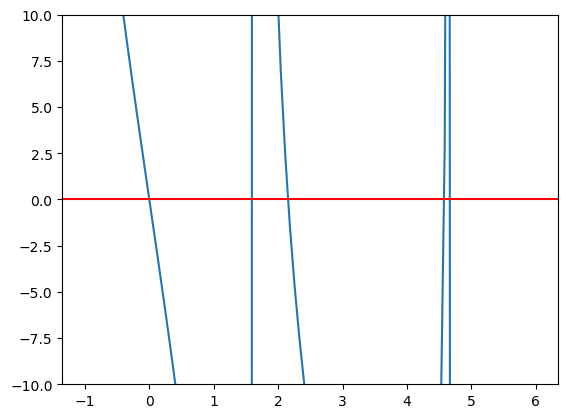

In [2]:
import scipy.optimize as opt

ns = 1
t= np.linspace(0,ns,1000)
mean, std = 0,np.sqrt(1e-4)

w = np.linspace(-1,6,100)

def tang_eq(x):
    return (x**2 - 16)*np.tan(x) - 8*x

# roots = []
# for i in [(1,2),(2,3)]:
#     roots.append(opt.bisect(tang_eq,i[0],i[1]))

########################################################################################
def roots_f(lam,M): #find solution of transcendental equation
    c = 1/lam
    g = lambda x: (np.tan(x) - (2*c*x)/(x**2-c**2))
    m = 1
    answer = np.zeros(M+1)
    for i in range(M):
        wmin = (i-0.499) * np.pi
        wmax = (i+0.499) * np.pi
        if wmin <= c and wmax >= c:
            if wmin > 0:
                answer[m] = fsolve(g, (c+wmin)/2)
                m = m + 1
            answer[m] = fsolve(g, (c+wmax)/2)
            m = m + 1
        elif wmin > 0:
            answer[m] = brentq(g,wmin,wmax)
            m = m + 1
    omega = answer[1:]
    return omega

lam = 1/4
#omega = roots(lam,2)
###################################################################################

roots = np.array(roots_f(lam,2))
theta_t = np.array([0.098, 0.430])

plt.plot(w, tang_eq(w))
plt.axhline(y = 0, color = 'r', linestyle = '-') 
plt.ylim(-10,10)


def k(x,theta,w):
    x = x.reshape(-1,1)

    A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
    
    bn =  A*(np.sin(w*x) + ((w)/(4))*np.cos(w*x))
    
    an = np.sqrt(8 / (w**2 + 16))

    return np.sum(an*bn*theta,axis=1)

def dk(x,theta,w):
    x = x.reshape(-1,1)

    A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
    
    bn =  A*w*(((w)/(4))*np.sin(w*x) - np.cos(w*x))
    
    an = np.sqrt(8 / (w**2 + 16))

    return np.sum(an*bn*theta,axis=1)


print(roots, k(np.array([0.6,0.7,0.9]),theta_t,roots), k(np.array([0.6,0.7,0.9]),theta_t,roots))

In [3]:
def fun_shock(x, y):

    def k(x,theta = theta_t,w =roots):
        x = x.reshape(-1,1)

        A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
        
        bn =  A*(np.sin(w*x) + ((w)/(4))*np.cos(w*x))
        
        an = np.sqrt(8 / (w**2 + 16))

        return np.sum(an*bn*theta,axis=1)

    def dk(x,theta = theta_t,w =roots):
        x = x.reshape(-1,1)

        A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
        
        bn =  A*w*(((w)/(4))*np.sin(w*x) - np.cos(w*x))
        
        an = np.sqrt(8 / (w**2 + 16))

        return np.sum(an*bn*theta,axis=1)
        
    return np.vstack(( y[1], -(4*x*np.exp(-k(x)) + dk(x)*y[1]) ))

def bc_shock(ya, yb):
    return np.array([ya[0], yb[0] - 2])

x_shock = np.linspace(0, 1, 10)
y_shock = np.zeros((2, x_shock.shape[0]))

In [4]:
res_shock = solve_bvp(fun_shock, bc_shock, x_shock, y_shock, verbose=2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.09e-03       1.12e-16          10              2       
       2          9.17e-04       8.58e-21          12              0       
Solved in 2 iterations, number of nodes 12. 
Maximum relative residual: 9.17e-04 
Maximum boundary residual: 8.58e-21


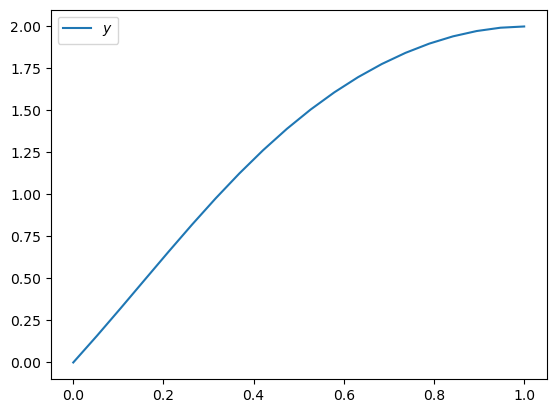

In [5]:
x_shock_plot = np.linspace(0, 1, 20)
y_shock_plot = res_shock.sol(x_shock_plot)

plt.plot(x_shock_plot, y_shock_plot[0], label='$y$')
plt.legend()

In [6]:
def test_set(max_space,obs,mean,std):

    t = np.linspace(0,max_space,obs)

    sol = res_shock.sol(t)

    noise_sol_test = sol[0] + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

## Feed Forward Neural Network

In [7]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        for param in self.parameters():
            if len(param.shape) > 1:
                torch.nn.init.xavier_normal_(param)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [8]:
def DE(self,t,pr,roots = torch.tensor(roots).float()):
    """ The pytorch autograd version of calculating residual """

    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t, 
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]
    
    def k(x,theta,w):

        A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
        bn =  A*(torch.sin(w*x) + ((w)/(4))*torch.cos(w*x))
    
        an = torch.sqrt(8 / (roots**2 + 16))

        return an*bn*theta
    
    def dk(x,theta,w):
        
        A = torch.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (torch.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (torch.cos(2*w)/8)))
    
        bn =  A*w*(-torch.cos(w*x) + ((w)/(4))*torch.sin(w*x))
    
        an = torch.sqrt(8 / (roots**2 + 16))

        return an*bn*theta

    dk_sum = torch.sum(dk(t,pr,roots),dim=1).reshape(-1,1)
    exp_k = torch.exp(torch.sum(k(t,pr,roots),dim=1)).reshape(-1,1)

    return dk_sum*exp_k*u_t + exp_k*u_tt + 4*t

In [9]:
DNN.DE = DE

In [10]:
def sample_ic(size):
    return np.zeros(size)

def sample_bc(size):
    return np.ones(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

# def samples_param(min,max,size = 100):
#     return min + np.random.rand(size)*(max - min)

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [11]:
def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
   print("Starting Training")

   #for epoch in range(epochs):
   itr_loss = 0.0   

   for i in range(epochs):

    ic,bc, t, param = sample_ic(size),sample_bc(size),samples_space(size,maxl),samples_param(minp,maxp,(size,theta_t.shape[0]))

    ic, bc, t = torch.tensor(ic).float().to(device),torch.tensor(bc).float().to(device), torch.tensor(t).float().to(device)
    param = torch.tensor(param).float().to(device)

    ic, bc ,t = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1)
    param =  Variable(param,requires_grad=True)

       
    def loss_func_train():
        
        optimizer.zero_grad()

        ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param], dim=1)), pinn(torch.cat([bc, param], dim=1)),pinn.DE(t,param)

        loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.ones_like(t)*2),loss(f_pred,torch.zeros_like(t))

        Loss =  loss_f + loss_u_ic + loss_u_bc

        if i % 10 == 0:
                print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
           
        Loss.backward() 
    
        return Loss

    optimizer.step(loss_func_train) 
    
    oupt = pinn(torch.cat([ic, param], dim=1))  

    loss_val = loss_func_train() 

    itr_loss += loss_val.item()  

In [12]:
# Number of observations
epochs = 40000
nobs = 2000
lr = 0.01

min_param , max_param = -1, 1

space = 1

layers = [3] + 2*[30] + [1]

In [13]:
model = DNN(layers)
loss = torch.nn.MSELoss(reduction ='mean')

In [14]:
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.3)

# train(epochs, model,loss,optimizer,nobs,space,min_param , max_param)

model.load_state_dict(torch.load("Param_model_T3.pt"))
model.eval()

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=30, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [15]:
# optimizer = torch.optim.LBFGS(
#     model.parameters(), lr=lr, max_iter=1000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
#     )
# train(1, model,loss,optimizer,nobs,space,min_param, max_param)


In [16]:
torch.save(model.state_dict(),"Param_model_T3.pt")

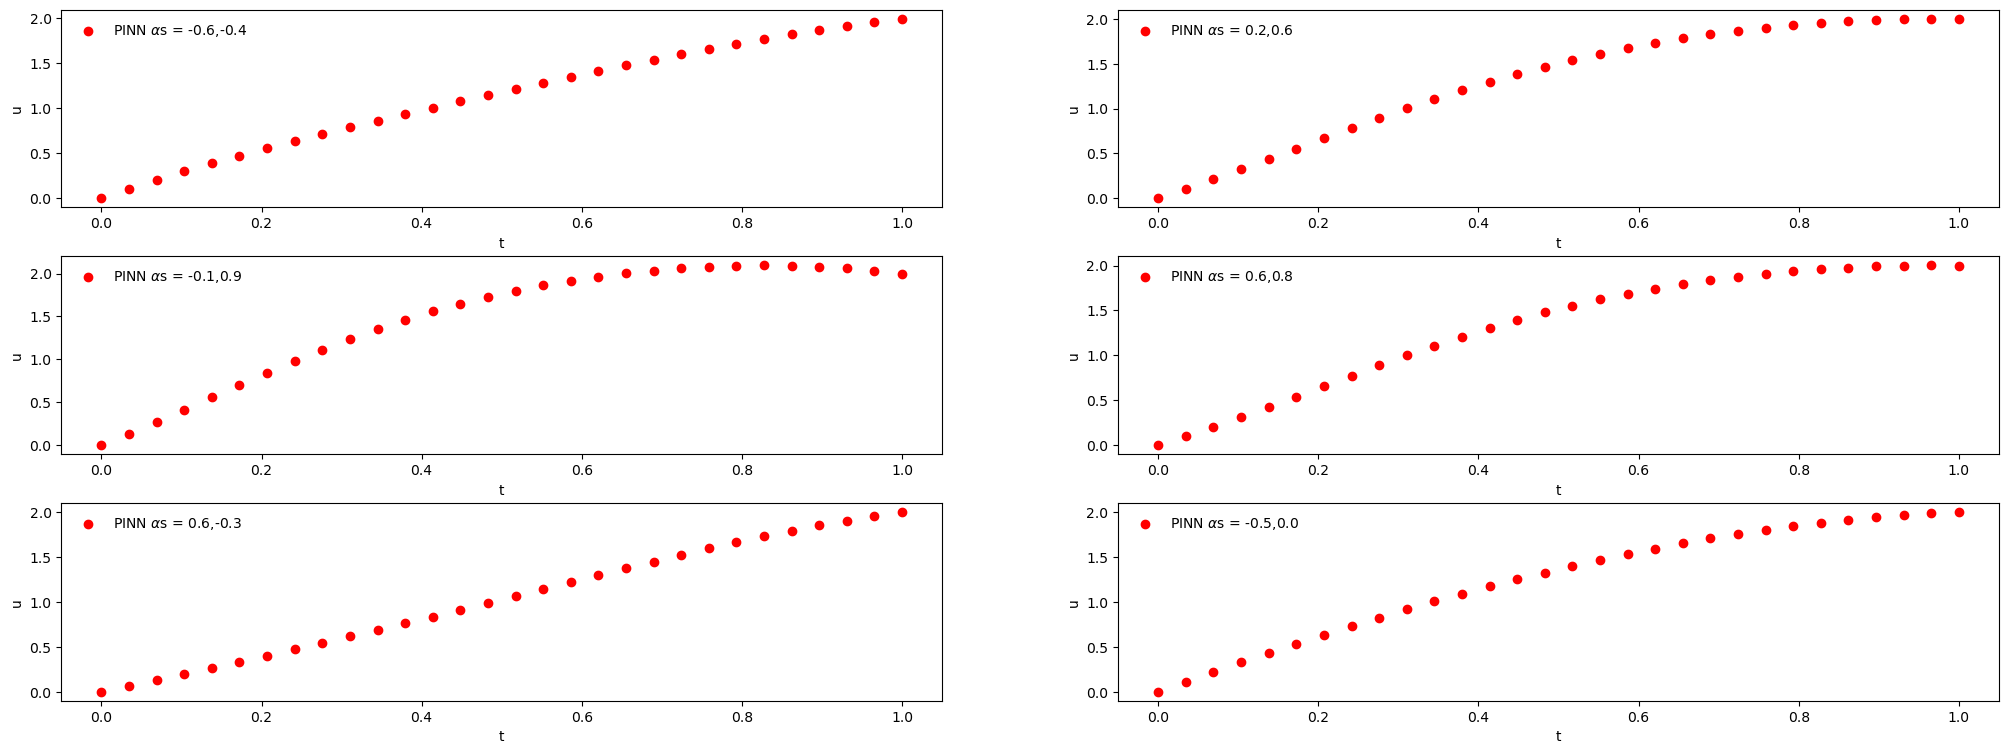

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm


param_trained =  samples_param(min_param , max_param,6)
param_trained2 =  samples_param(min_param , max_param,6)


# Plotting
fig = plt.figure(figsize=(25,25))
plt.subplots_adjust(hspace=0.25)

for n,(pr1,pr2) in enumerate(zip(param_trained,param_trained2)):

    t, noise_sol_test = test_set(ns,30,mean,std)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr1), np.ones_like(t).flatten()[:,None]*(pr2)))

    u_pred = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    plt.subplot(8, 2, n + 1)

    plt.scatter(t, u_pred, label = fr"PINN $\alpha$s = {pr1:.1f},{pr2:.1f}", color = "red")

    #plt.scatter(t,-(2/3)*t**3 + 2.5*t, label = "Observations",color= "blue",alpha = 0.5)

    plt.xlabel("t")
    plt.ylabel("u")
    plt.legend(frameon=False)

## MCMC Step

In [18]:
def log_prior_alpha(pr): #function to evaluate prior pdf of given parameters
    #return norm.logpdf(pr1,loc = 0,scale = 1.5) + norm.logpdf(pr2,loc = 0,scale = 1.5)
    return np.sum(uniform(loc = -1, scale = 2).logpdf(pr))

def proposals(alpha,dt):
    return np.random.normal(alpha,dt,size=2)

In [19]:
def log_likelihood(surrogate,pr,t,y_dat,sig = std):
    pr1,pr2 = pr
    
    data_ =  np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr1), np.ones_like(t).flatten()[:,None]*(pr2)))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

In [20]:
def log_posterior_nn(model,pr,t,y):
    return  log_likelihood(model,pr,t,y) + log_prior_alpha(pr)

In [21]:
def Metropolis_Hastings(t,y_dat,nChains):

    alpha = np.array([0.5,0.5])

    alpha_samp,dt_tracker = np.zeros((nChains,alpha.shape[0])),np.zeros((nChains,1))
    acceptance_rate, dt = 0, 0.5

    for i in range(nChains):

        log_posterior =  log_posterior_nn(model,alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_nn(model,alpha_proposal,t,y_dat)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if np.random.uniform(0,1) < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker[i] = dt
        alpha_samp[i,:] = alpha

    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [22]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [36]:
t = np.array([0] + list(np.linspace(0.2,0.8,6)) + [1])

y_shock_plot = res_shock.sol(t)
y_shock_plot_ = y_shock_plot[0]

y_shock_plot = np.array([0,4.257174963573532311e-01, 6.704236569661589096e-01, 9.221336565815004827e-01,1.185151034069622744e+00,1.451691910058344304e+00,
                            1.700335624196542383e+00,2])

noise_sol_test = y_shock_plot +  np.random.normal(mean,std, len(t))

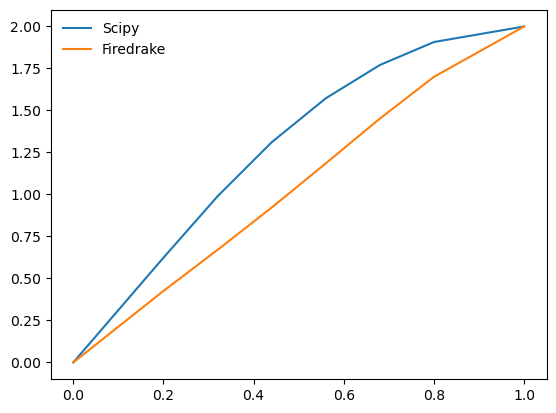

In [33]:
plt.plot(t,y_shock_plot_, label = "Scipy")
plt.plot(t,y_shock_plot,label = "Firedrake")

plt.legend(frameon = False)

In [37]:
alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,100000)

/tmp/ipykernel_5398/76598558.py:16: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.102


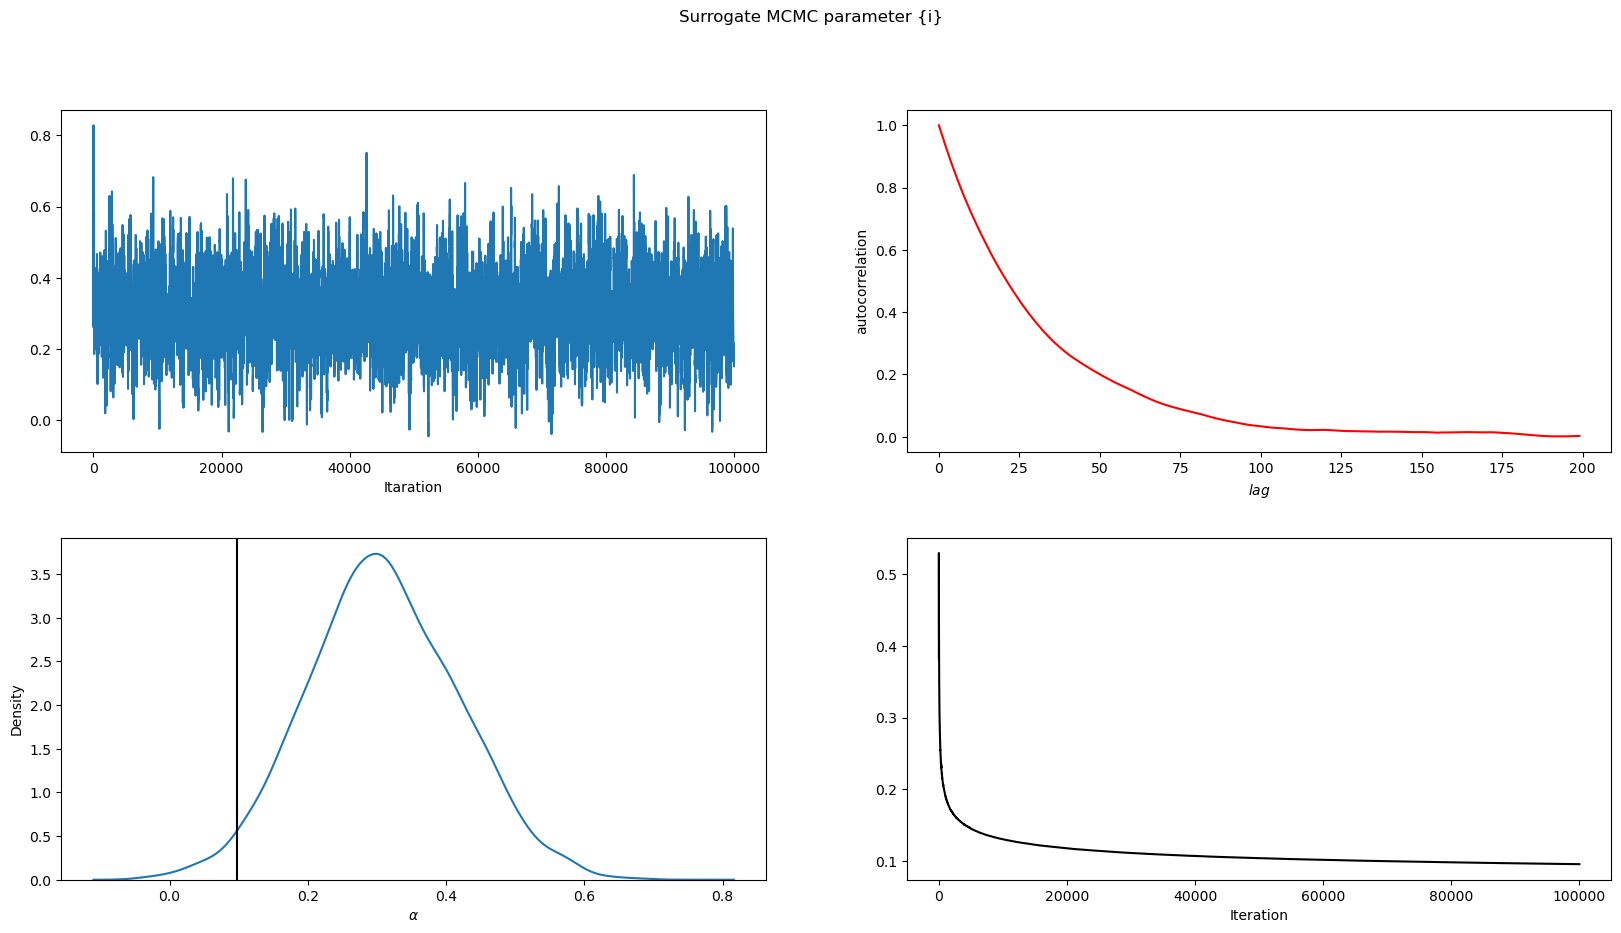

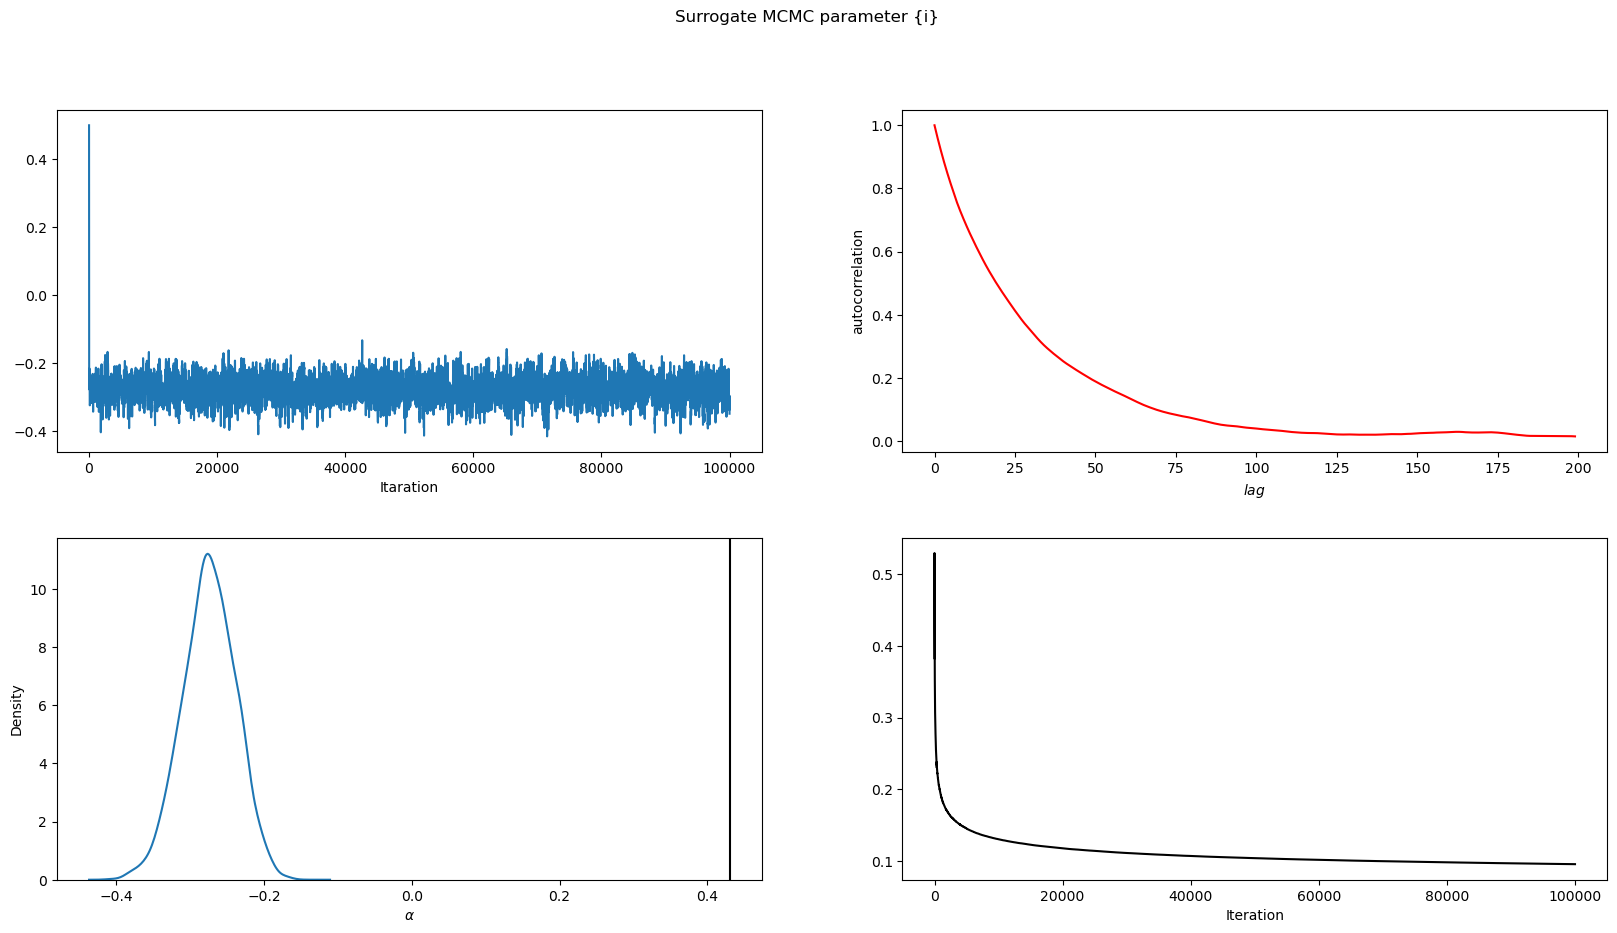

In [38]:
import seaborn as sns


for i in range(alpha_samp.shape[1]):

    fig = plt.figure(figsize=(20,10))

    plt.suptitle("Surrogate MCMC parameter {i}")
    plt.subplots_adjust(hspace=0.25)

    plt.subplot(2, 2, 1)
    plt.plot(alpha_samp[:,i])
    plt.xlabel("Itaration")

    plt.subplot(2, 2, 2)
    plt.plot(acf(alpha_samp[:,i],200),color = "red")
    plt.xlabel(r"$lag$")
    plt.ylabel(r"autocorrelation")


    plt.subplot(2, 2, 3)
    #plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
    #plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
    sns.kdeplot(alpha_samp[200:,i],bw_adjust=2)
    plt.axvline(x = theta_t[i], color = 'black', label = 'Real')
    plt.xlabel(r"$\alpha$")
    #plt.xlim(0.3,0.32)

    plt.subplot(2, 2, 4)
    plt.plot(dt_tracker,color = "black")
    plt.xlabel("Iteration")

    plt.plot()

## Scipy Solution

In [40]:
noise_sol_test = y_shock_plot_ +  np.random.normal(mean,std, len(t))

alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,100000)

Acceptance Rate: 0.109


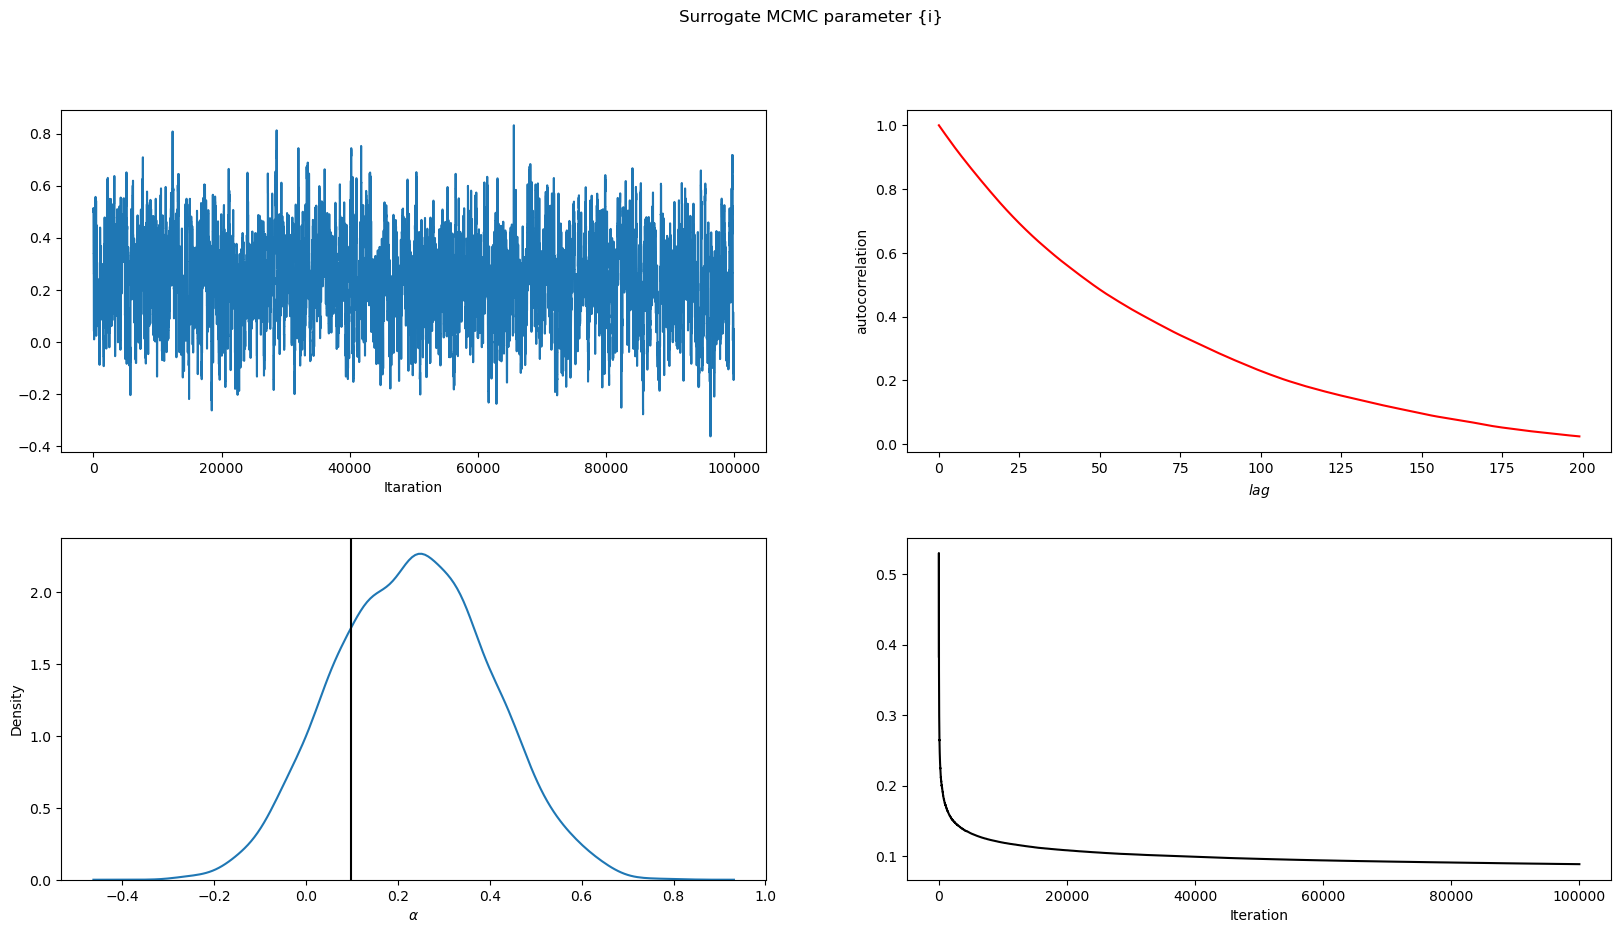

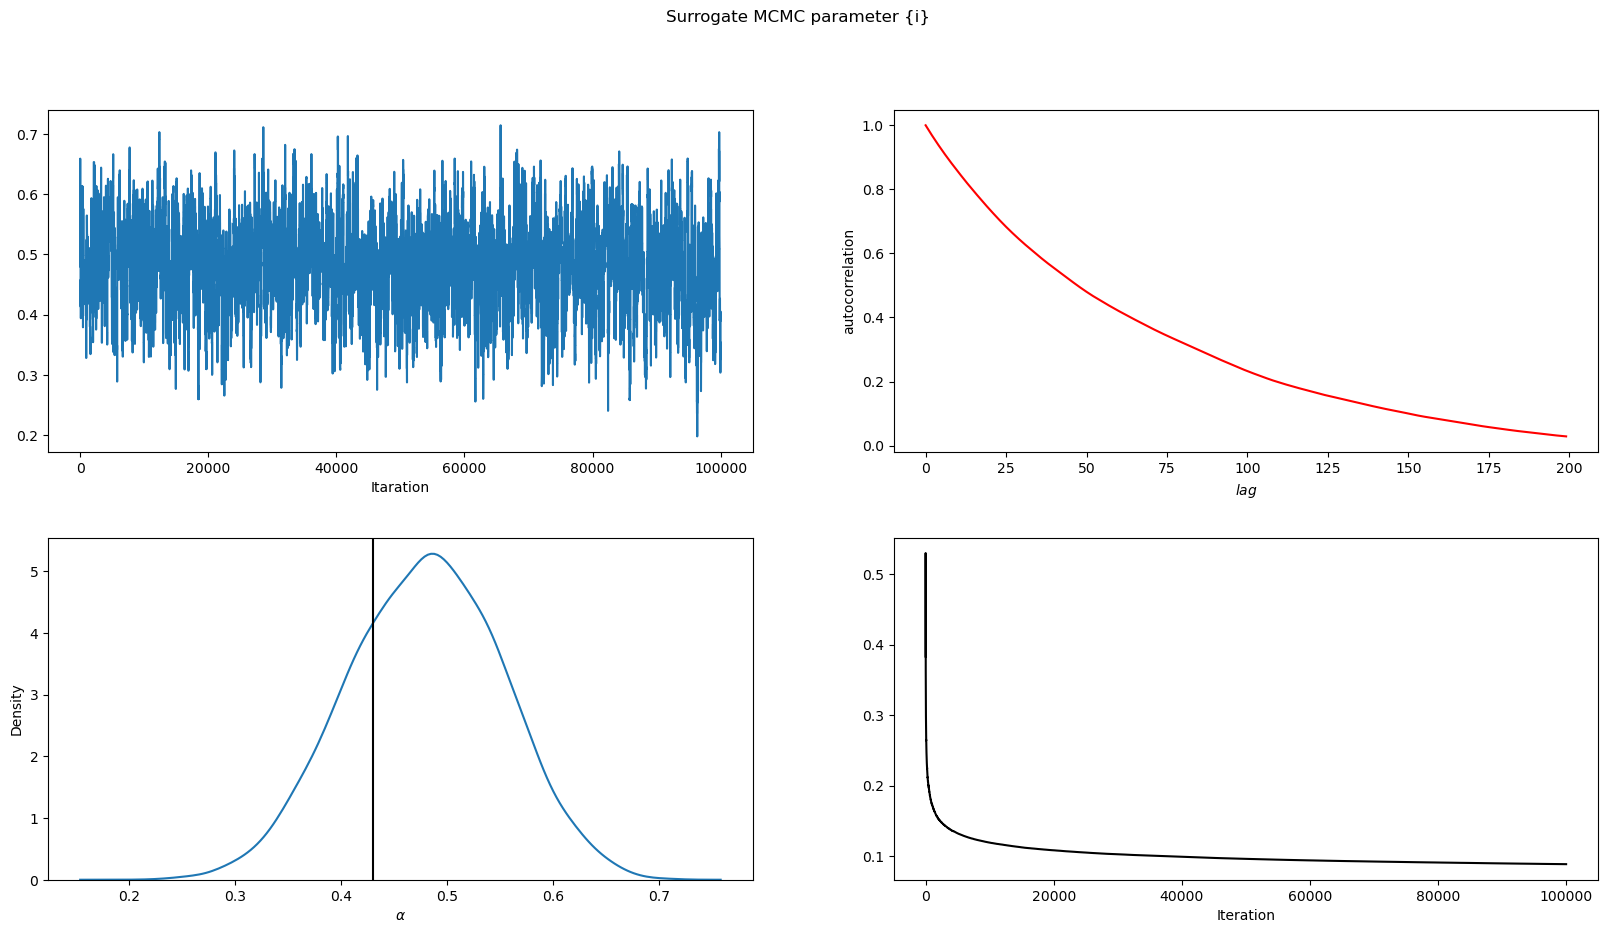

In [41]:
for i in range(alpha_samp.shape[1]):

    fig = plt.figure(figsize=(20,10))

    plt.suptitle("Surrogate MCMC parameter {i}")
    plt.subplots_adjust(hspace=0.25)

    plt.subplot(2, 2, 1)
    plt.plot(alpha_samp[:,i])
    plt.xlabel("Itaration")

    plt.subplot(2, 2, 2)
    plt.plot(acf(alpha_samp[:,i],200),color = "red")
    plt.xlabel(r"$lag$")
    plt.ylabel(r"autocorrelation")


    plt.subplot(2, 2, 3)
    #plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
    #plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
    sns.kdeplot(alpha_samp[200:,i],bw_adjust=2)
    plt.axvline(x = theta_t[i], color = 'black', label = 'Real')
    plt.xlabel(r"$\alpha$")
    #plt.xlim(0.3,0.32)

    plt.subplot(2, 2, 4)
    plt.plot(dt_tracker,color = "black")
    plt.xlabel("Iteration")

    plt.plot()